### 赛题说明
https://2019ai.futurelab.tv/contest_detail/3#contest_des

### 2.数据概况

In [17]:
#coding :utf-8
#导入warnings包，利用过滤器来时实现忽略警告语句。
import warnings
warnings.filterwarnings('ignore')

#GBDT
from sklearn.ensemble import GradientBoostingRegressor  #注意是回归
#XGBoost
import xgboost as xgb
#LightGBM
import lightgbm as lgb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
#载入数据
data_train = pd.read_csv('../data/train_data.csv')
data_train['Type'] = 'Train'  #新建一个type字段区分训练集合测试集
data_test = pd.read_csv('../data/test_a.csv')
data_test['Type'] = 'Test'
data_all = pd.concat([data_train, data_test], ignore_index=True) #序号重新排列

In [19]:
data_train.head()

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,...,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney,Type
0,100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,SH,...,0.0000,28248,614,111546,1124.0,284.0,0,2018/11/28,2000.0,Train
1,100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,SH,...,0.0000,14823,148,157552,701.0,22.0,1,2018/12/16,2000.0,Train
2,100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,SH,...,0.0000,77645,520,131744,57.0,20.0,1,2018/12/22,16000.0,Train
3,100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,SH,...,3080.0331,8750,1665,253337,888.0,279.0,9,2018/12/21,1600.0,Train
4,100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,SH,...,0.0000,800,117,125309,2038.0,480.0,0,2018/11/18,2900.0,Train


### 3.总体情况一览

In [20]:
#41440个样本，51特征
data_train.shape 

(41440, 52)

In [21]:
#可以看到pv 和 uv 缺失了18个
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41440 entries, 0 to 41439
Data columns (total 52 columns):
ID                    41440 non-null int64
area                  41440 non-null float64
rentType              41440 non-null object
houseType             41440 non-null object
houseFloor            41440 non-null object
totalFloor            41440 non-null int64
houseToward           41440 non-null object
houseDecoration       41440 non-null object
communityName         41440 non-null object
city                  41440 non-null object
region                41440 non-null object
plate                 41440 non-null object
buildYear             41440 non-null object
saleSecHouseNum       41440 non-null int64
subwayStationNum      41440 non-null int64
busStationNum         41440 non-null int64
interSchoolNum        41440 non-null int64
schoolNum             41440 non-null int64
privateSchoolNum      41440 non-null int64
hospitalNum           41440 non-null int64
drugStoreNum       

In [22]:
print(data_train.describe())
#大致观察下，
#area:住房面积最小有1平米
#totalFloor：房间所在总楼层数有0层么，最大88层
#....数值型的25个

                 ID          area    totalFloor  saleSecHouseNum  \
count  4.144000e+04  41440.000000  41440.000000     41440.000000   
mean   1.001221e+08     70.959409     11.413152         1.338538   
std    9.376566e+04     88.119569      7.375203         3.180349   
min    1.000000e+08      1.000000      0.000000         0.000000   
25%    1.000470e+08     42.607500      6.000000         0.000000   
50%    1.000960e+08     65.000000      7.000000         0.000000   
75%    1.001902e+08     90.000000     16.000000         1.000000   
max    1.003218e+08  15055.000000     88.000000        52.000000   

       subwayStationNum  busStationNum  interSchoolNum     schoolNum  \
count      41440.000000   41440.000000    41440.000000  41440.000000   
mean           5.741192     187.197153        1.506395     48.228813   
std            4.604929     179.674625        1.687631     29.568448   
min            0.000000      24.000000        0.000000      9.000000   
25%            2.000000    

In [23]:
data_train.head()

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,...,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney,Type
0,100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,SH,...,0.0000,28248,614,111546,1124.0,284.0,0,2018/11/28,2000.0,Train
1,100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,SH,...,0.0000,14823,148,157552,701.0,22.0,1,2018/12/16,2000.0,Train
2,100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,SH,...,0.0000,77645,520,131744,57.0,20.0,1,2018/12/22,16000.0,Train
3,100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,SH,...,3080.0331,8750,1665,253337,888.0,279.0,9,2018/12/21,1600.0,Train
4,100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,SH,...,0.0000,800,117,125309,2038.0,480.0,0,2018/11/18,2900.0,Train


#### 简要分析
该份训练集包含 41440行×52列数据  
目标变量是 真实房租价格： tradeMoney 

大多数数据都是int或float型；
**<font color='red'>有部分字段是object型，即文本型中文或英文的，
如rentType字段，这些字段在之后需要做处理  **

In [24]:
data_train.shape

(41440, 52)

### 4. 分类特征和连续型特征
https://blog.csdn.net/lujiandong1/article/details/49448051   
处理离散型特征和连续型特征共存的情况



In [32]:
# 根据特征含义和特征一览，大致可以判断出数值型和类别型特征如下
categorical_feas = ['rentType', 'houseType', 'houseFloor', 'region', 'plate', 'houseToward', 'houseDecoration',
    'communityName','city','buildYear']

numerical_feas=['ID','area','totalFloor','saleSecHouseNum','subwayStationNum',
    'busStationNum','interSchoolNum','schoolNum','privateSchoolNum','hospitalNum',
    'drugStoreNum','gymNum','bankNum','shopNum','parkNum','mallNum','superMarketNum',
    'totalTradeMoney','totalTradeArea','tradeMeanPrice','tradeSecNum','totalNewTradeMoney',
    'totalNewTradeArea','tradeNewMeanPrice','tradeNewNum','remainNewNum','supplyNewNum',
    'supplyLandNum','supplyLandArea','tradeLandNum','tradeLandArea','landTotalPrice',
    'landMeanPrice','totalWorkers','newWorkers','residentPopulation','pv','uv','lookNum']

### 5.缺失值分析

In [33]:
# 缺失值分析
def missing_values(df):
    alldata_na = pd.DataFrame(df.isnull().sum(), columns={'missingNum'})
    alldata_na['existNum'] = len(df) - alldata_na['missingNum']
    alldata_na['sum'] = len(df)
    alldata_na['missingRatio'] = alldata_na['missingNum']/len(df)*100
    alldata_na['dtype'] = df.dtypes
    #ascending：默认True升序排列；False降序排列
    #按缺失值(missingNum)降序，index升序(字典序？)
    alldata_na = alldata_na[alldata_na['missingNum']>0].reset_index().sort_values(by=['missingNum','index'],ascending=[False,True])
    alldata_na.set_index('index',inplace=True)
    return alldata_na

missing_values(data_train)

,missingNum,existNum,sum,missingRatio,dtype
index,,,,,
pv,18,41422,41440,0.043436,float64
uv,18,41422,41440,0.043436,float64


In [34]:
# alldata_na = pd.DataFrame(data_train.isnull().sum(),columns={'missingNum'})

In [35]:
# len(data_train)- allata_na.missingNum

In [36]:
# data_train.dtypes

In [37]:
# alldata_na[alldata_na['missingNum']>0].reset_index().sort_values(by=['missingNum','index'],ascending=[False,True])

**简要分析**  
<font color = 'red'>这里采用编写函数的方式来直接获取结果（这种方式会在之后反复用到，建议大家尽早养成函数式编写的习惯）；</font>  
其实在总体情况一览中，info()函数也能看出来。  

<font color='green'>结果是，仅有pv、uv存在缺失值，后面再探究会发现缺失的都是属于同一个plate，可能是官方直接删除了该plate的pv、uv </font>   
plate:区域或板块


### 6. 单调特征列分析  
找单调特征列？

In [38]:
#是否有单调特征列(单调的特征列很大可能是时间)
def incresing(vals):
    cnt = 0
    len_ = len(vals)
    for i in range(len_-1):
        if vals[i+1] > vals[i]:
            cnt += 1
    return cnt

fea_cols = [col for col in data_train.columns]
for col in fea_cols:
    cnt = incresing(data_train[col].values)
    if cnt / data_train.shape[0] >= 0.55:
        print('单调特征：',col)
        print('单调特征值个数：', cnt)
        print('单调特征值比例：', cnt / data_train.shape[0])

单调特征： tradeTime
单调特征值个数： 24085
单调特征值比例： 0.5812017374517374


**简要分析**  
先编写判断单调的函数 incresing， 然后再应用到每列上；  
单调特征是 tradeTime，为时间列。  

多说句额外的，时间列在特征工程的时候，不同的情况下能有很多的变种形式，比如按年月日分箱，或者按不同的维度在时间上聚合分组，等等



### 7. 特征nunique分布

In [16]:
# 特征nunique分布
# for feature in categorical_feas:
#     print(feature + "的特征分布如下：")
#     print(data_train[feature].value_counts())
#     if feature != 'communityName': # communityName值太多，暂且不看图表
#         plt.hist(data_all[feature], bins=3)
#         plt.show()

**简要分析**
用自带函数value_counts() 来得到每个分类变量的 种类 分布；  
并且简单画出柱状图。  

rentType：4种，且绝大多数是无用的未知方式；  
houseType：104种，绝大多数在3室及以下；  
houseFloor：3种，分布较为均匀；  
region： 15种；  
plate： 66种；  
houseToward： 10种；  
houseDecoration： 4种，一大半是其他；  
buildYear： 80种；  
communityName： 4236种，且分布较为稀疏；  

此步骤是为之后数据处理和特征工程做准备，先理解每个字段的含义以及分布，之后需要根据实际含义对分类变量做不同的处理。  

In [42]:
data_train['city'].unique()

array(['SH'], dtype=object)

### 8. 统计特征值频次大于100的特征  
<font color ='red'>100随便选的吗</font>

In [43]:
# 统计特征值出现频次大于100的特征
for feature in categorical_feas:
    df_value_counts = pd.DataFrame(data_train[feature].value_counts())
    df_value_counts = df_value_counts.reset_index()
    df_value_counts.columns = [feature, 'counts'] # change column names
    print(df_value_counts[df_value_counts['counts'] >= 100])

  rentType  counts
0     未知方式   30759
1       整租    5472
2       合租    5204
   houseType  counts
0     1室1厅1卫    9805
1     2室1厅1卫    8512
2     2室2厅1卫    6783
3     3室1厅1卫    3992
4     3室2厅2卫    2737
5     4室1厅1卫    1957
6     3室2厅1卫    1920
7     1室0厅1卫    1286
8     1室2厅1卫     933
9     2室2厅2卫     881
10    4室2厅2卫     435
11    2室0厅1卫     419
12    4室2厅3卫     273
13    5室1厅1卫     197
14    2室1厅2卫     155
15    3室2厅3卫     149
16    3室1厅2卫     135
  houseFloor  counts
0          中   15458
1          高   14066
2          低   11916
     region  counts
0   RG00002   11437
1   RG00005    5739
2   RG00003    4186
3   RG00010    3640
4   RG00012    3368
5   RG00004    3333
6   RG00006    1961
7   RG00007    1610
8   RG00008    1250
9   RG00013    1215
10  RG00001    1157
11  RG00014    1069
12  RG00011     793
13  RG00009     681
      plate  counts
0   BK00031    1958
1   BK00033    1837
2   BK00045    1816
3   BK00055    1566
4   BK00056    1516
5   BK00052    1375
6   BK00017    1305
7 

**简要分析**   
此步骤和特征nunique分布结合步骤结合起来看，有一些小于100的是可以直接统一归类为其他的  

### 9. Label分布

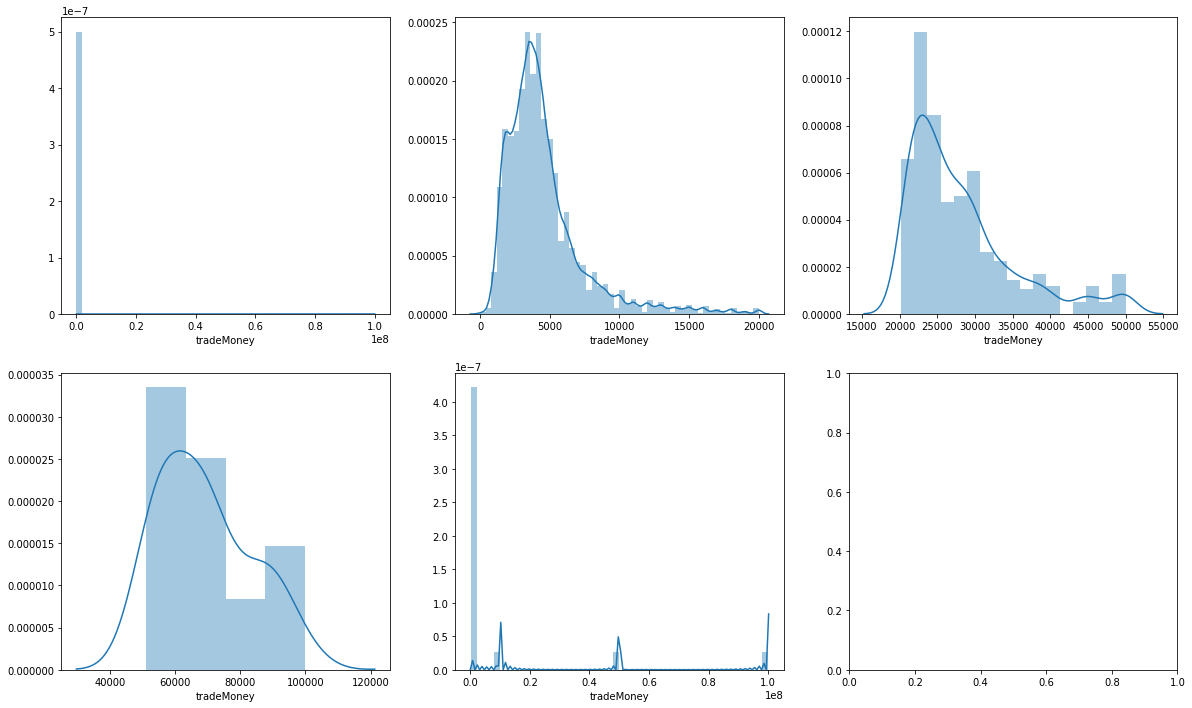

In [45]:
# Labe 分布
fig,axes = plt.subplots(2,3,figsize=(20,5))
fig.set_size_inches(20,12)
sns.distplot(data_train['tradeMoney'],ax=axes[0][0])
sns.distplot(data_train[(data_train['tradeMoney']<=20000)]['tradeMoney'],ax=axes[0][1])
sns.distplot(data_train[(data_train['tradeMoney']>20000)&(data_train['tradeMoney']<=50000)]['tradeMoney'],ax=axes[0][2])
sns.distplot(data_train[(data_train['tradeMoney']>50000)&(data_train['tradeMoney']<=100000)]['tradeMoney'],ax=axes[1][0])
sns.distplot(data_train[(data_train['tradeMoney']>100000)]['tradeMoney'],ax=axes[1][1])

——————————————————————————————————————————————————————————————————————

In [80]:
#检查数据的相关性
# corr = data_train.corr()
# plt.figure(figsize=(19,15))
# sns.heatmap(corr,annot=True,fmt='.2g')

In [90]:
data_all.head()

,ID,Type,area,bankNum,buildYear,busStationNum,city,communityName,drugStoreNum,gymNum,...,totalWorkers,tradeLandArea,tradeLandNum,tradeMeanPrice,tradeMoney,tradeNewMeanPrice,tradeNewNum,tradeSecNum,tradeTime,uv
0,100309852,Train,68.06,16,1953,36,SH,XQ00051,12,15,...,28248,0.0,0,47974.22551,2000.0,104573.48460,25,111,2018/11/28,284.0
1,100307942,Train,125.55,16,2007,184,SH,XQ00130,27,5,...,14823,0.0,0,40706.66775,2000.0,33807.53497,2,2,2018/12/16,22.0
2,100307764,Train,132.00,37,暂无信息,60,SH,XQ00179,24,35,...,77645,0.0,0,34384.35089,16000.0,109734.16040,11,555,2018/12/22,20.0
3,100306518,Train,57.00,47,暂无信息,364,SH,XQ00313,83,30,...,8750,108037.8,1,20529.55050,1600.0,30587.07058,58,260,2018/12/21,279.0
4,100305262,Train,129.00,10,暂无信息,141,SH,XQ01257,21,5,...,800,0.0,0,24386.36577,2900.0,51127.32846,34,38,2018/11/18,480.0


In [91]:
data_all[['area','totalFloor','saleSecHouseNum','subwayStationNum',
    'busStationNum','interSchoolNum','schoolNum','privateSchoolNum','hospitalNum',
    'drugStoreNum','gymNum','bankNum','shopNum','parkNum','mallNum','superMarketNum',
    'totalTradeMoney','totalTradeArea','tradeMeanPrice','tradeSecNum','totalNewTradeMoney',
    'totalNewTradeArea','tradeNewMeanPrice','tradeNewNum','remainNewNum','supplyNewNum',
    'supplyLandNum','supplyLandArea','tradeLandNum','tradeLandArea','landTotalPrice',
    'landMeanPrice','totalWorkers','newWorkers','residentPopulation','lookNum']].isnull().sum()

area                  0
totalFloor            0
saleSecHouseNum       0
subwayStationNum      0
busStationNum         0
interSchoolNum        0
schoolNum             0
privateSchoolNum      0
hospitalNum           0
drugStoreNum          0
gymNum                0
bankNum               0
shopNum               0
parkNum               0
mallNum               0
superMarketNum        0
totalTradeMoney       0
totalTradeArea        0
tradeMeanPrice        0
tradeSecNum           0
totalNewTradeMoney    0
totalNewTradeArea     0
tradeNewMeanPrice     0
tradeNewNum           0
remainNewNum          0
supplyNewNum          0
supplyLandNum         0
supplyLandArea        0
tradeLandNum          0
tradeLandArea         0
landTotalPrice        0
landMeanPrice         0
totalWorkers          0
newWorkers            0
residentPopulation    0
lookNum               0
dtype: int64

In [88]:
#去掉id，pv,uv 缺失值的
numerical_feas=['area','totalFloor','saleSecHouseNum','subwayStationNum',
    'busStationNum','interSchoolNum','schoolNum','privateSchoolNum','hospitalNum',
    'drugStoreNum','gymNum','bankNum','shopNum','parkNum','mallNum','superMarketNum',
    'totalTradeMoney','totalTradeArea','tradeMeanPrice','tradeSecNum','totalNewTradeMoney',
    'totalNewTradeArea','tradeNewMeanPrice','tradeNewNum','remainNewNum','supplyNewNum',
    'supplyLandNum','supplyLandArea','tradeLandNum','tradeLandArea','landTotalPrice',
    'landMeanPrice','totalWorkers','newWorkers','residentPopulation','lookNum']

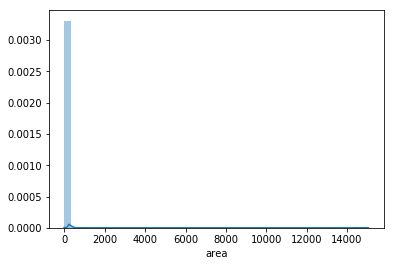

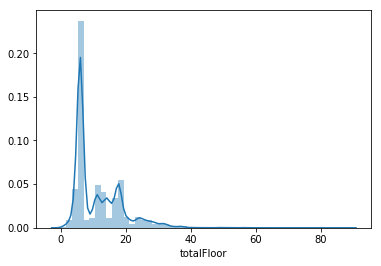

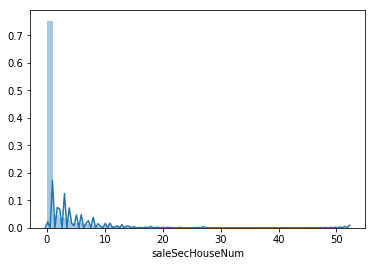

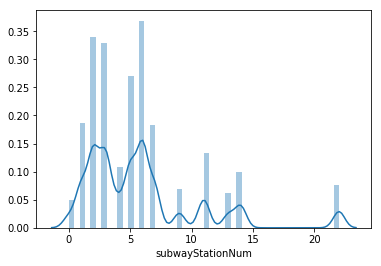

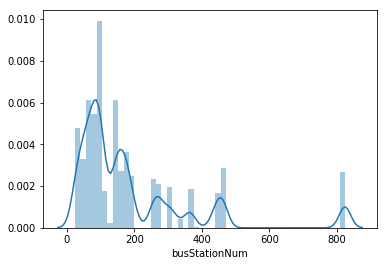

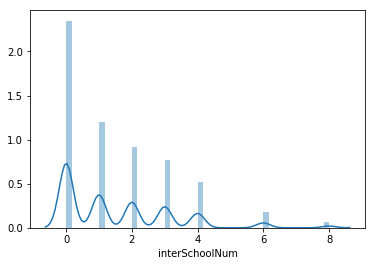

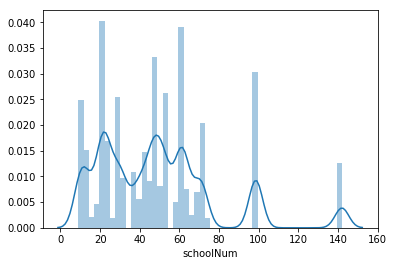

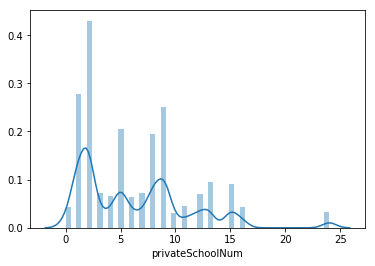

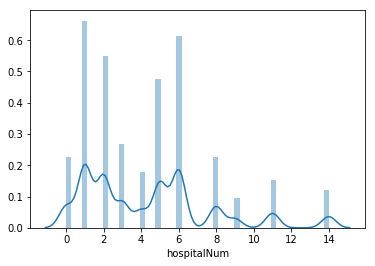

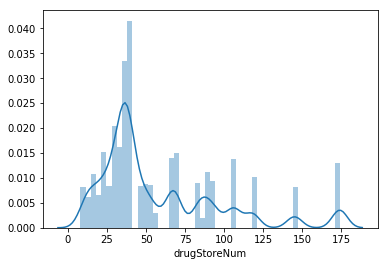

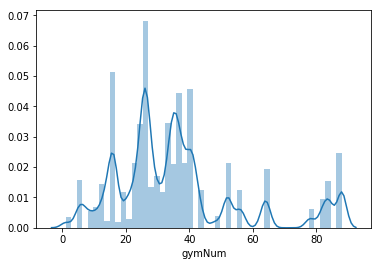

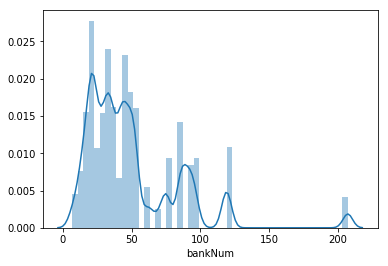

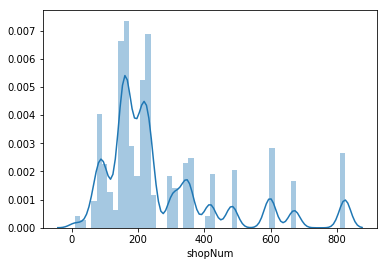

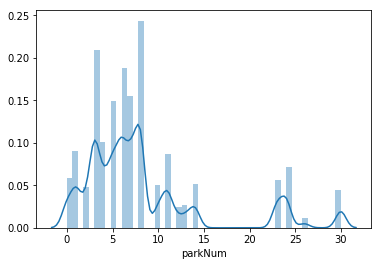

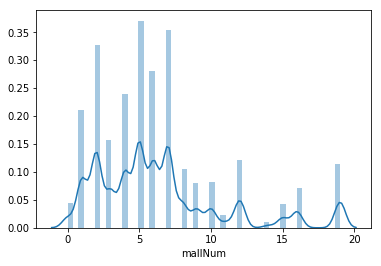

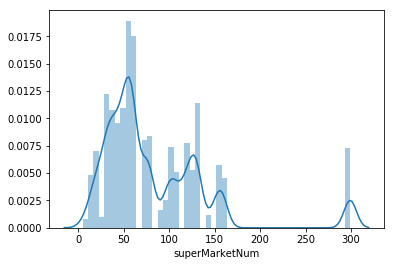

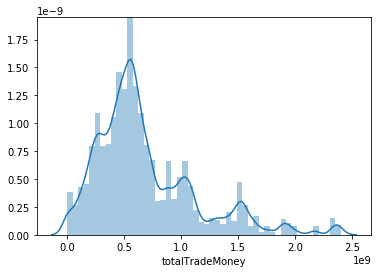

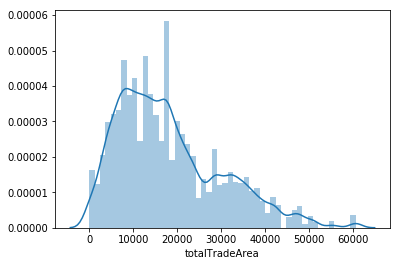

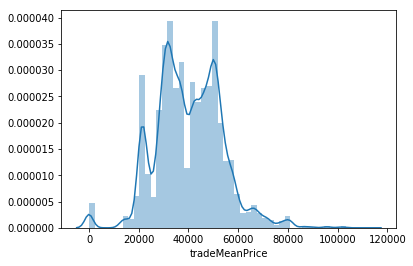

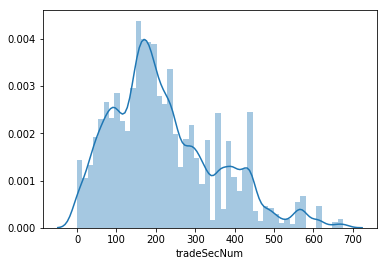

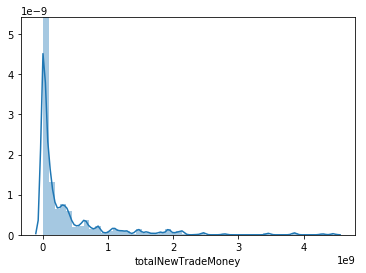

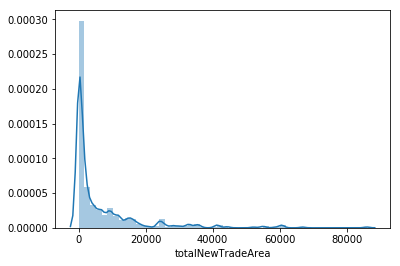

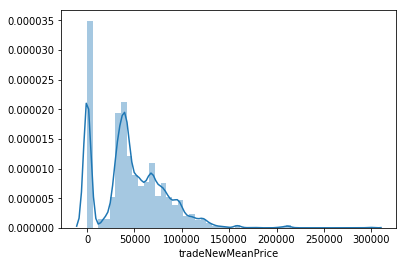

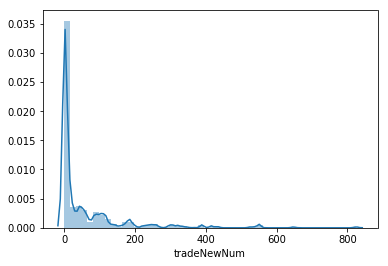

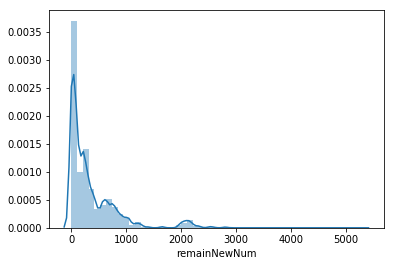

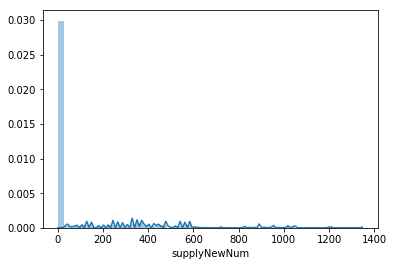

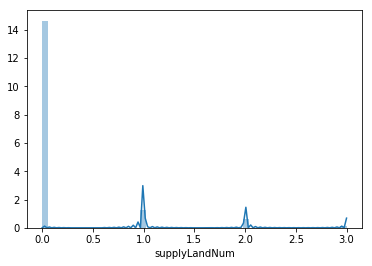

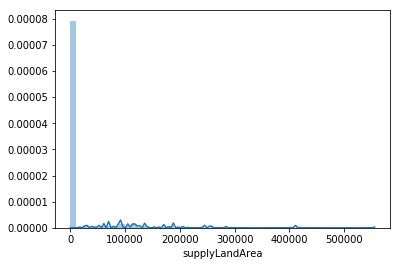

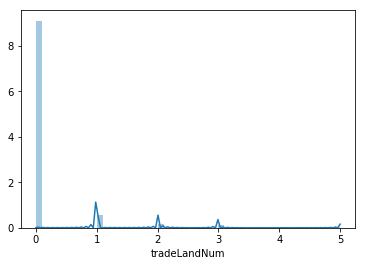

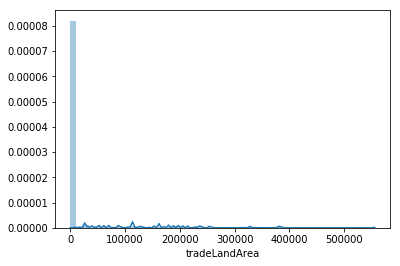

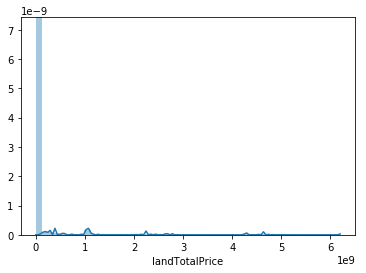

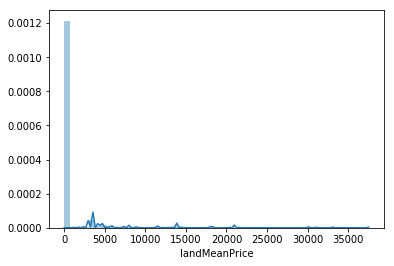

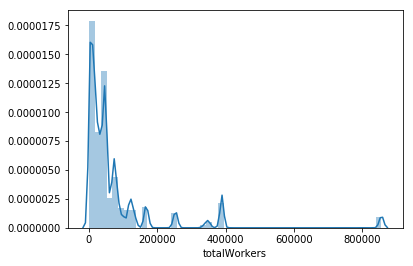

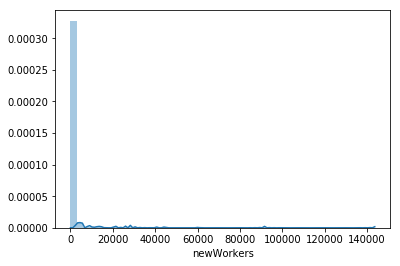

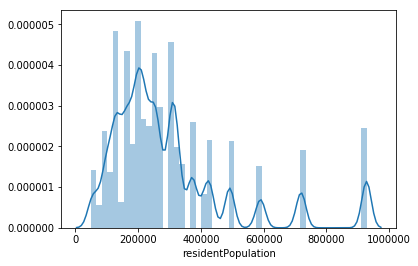

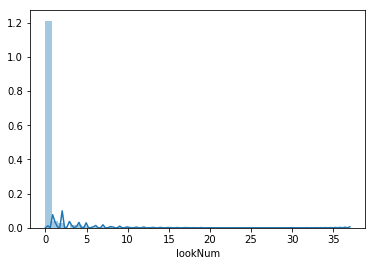

In [92]:
for each in numerical_feas:
    sns.distplot(data_all[each])
    plt.show()
#以下特征为偏态除了tradeMeanPrice

In [94]:
data_all.head()

,ID,Type,area,bankNum,buildYear,busStationNum,city,communityName,drugStoreNum,gymNum,...,totalWorkers,tradeLandArea,tradeLandNum,tradeMeanPrice,tradeMoney,tradeNewMeanPrice,tradeNewNum,tradeSecNum,tradeTime,uv
0,100309852,Train,68.06,16,1953,36,SH,XQ00051,12,15,...,28248,0.0,0,47974.22551,2000.0,104573.48460,25,111,2018/11/28,284.0
1,100307942,Train,125.55,16,2007,184,SH,XQ00130,27,5,...,14823,0.0,0,40706.66775,2000.0,33807.53497,2,2,2018/12/16,22.0
2,100307764,Train,132.00,37,暂无信息,60,SH,XQ00179,24,35,...,77645,0.0,0,34384.35089,16000.0,109734.16040,11,555,2018/12/22,20.0
3,100306518,Train,57.00,47,暂无信息,364,SH,XQ00313,83,30,...,8750,108037.8,1,20529.55050,1600.0,30587.07058,58,260,2018/12/21,279.0
4,100305262,Train,129.00,10,暂无信息,141,SH,XQ01257,21,5,...,800,0.0,0,24386.36577,2900.0,51127.32846,34,38,2018/11/18,480.0


In [ ]:
#Take a log transformation to see if distribution can be less skewed.
log_trans_list = 